# Proyecto 1 – Atención de Incidentes  
## Tarea 4 – Modelamiento

Exploración de diferentes configuraciones de modelo, realizar ingeniería de características, emplear diferentes métodos de estimación, comparar y seleccionar las mejores
alternativas.

Empecemos importando numpy y pandas

In [2]:
import numpy as np
import pandas as pd

Carguemos el archivo incident_event_log.csv usando pandas.

In [4]:
df = pd.read_csv("incident_event_log.csv")
df.head()

,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,...,u_priority_confirmation,notify,problem_id,rfc,vendor,caused_by,closed_code,resolved_by,resolved_at,closed_at
0,INC0000045,New,True,0,0,0,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
1,INC0000045,Resolved,True,0,0,2,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
2,INC0000045,Resolved,True,0,0,3,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
3,INC0000045,Closed,False,0,0,4,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
4,INC0000047,New,True,0,0,0,True,Caller 2403,Opened by 397,29/2/2016 04:40,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 81,1/3/2016 09:52,6/3/2016 10:00


In [43]:
df.isna().sum()

number                        0
incident_state                0
active                        0
reassignment_count            0
reopen_count                  0
sys_mod_count                 0
made_sla                      0
caller_id                     0
opened_by                     0
opened_at                     0
sys_created_by                0
sys_created_at                0
sys_updated_by                0
sys_updated_at                0
contact_type                  0
location                      0
category                      0
subcategory                   0
u_symptom                     0
cmdb_ci                       0
impact                        0
urgency                       0
priority                      0
assignment_group              0
assigned_to                   0
knowledge                     0
u_priority_confirmation       0
notify                        0
problem_id                    0
rfc                           0
vendor                        0
caused_b

In [44]:
df.dropna(inplace=True)

Ahora construyamos un DataFrame con la información que vamos a requerir para la construcción del modelo.

In [45]:
# Primero, convertir las columnas de fecha a tipo datetime.
df['opened_at'] = pd.to_datetime(df['opened_at'], errors='coerce')
df['resolved_at'] = pd.to_datetime(df['resolved_at'], errors='coerce')


In [46]:
df_modelo = pd.DataFrame()
df_modelo['time_to_resolve'] = (df['resolved_at'] - df['opened_at']).dt.total_seconds() / 3600.0
df_modelo['reassignment_count'] = df['reassignment_count']
df_modelo['sys_mod_count'] = df['sys_mod_count']
df_modelo['reopen_count'] = df['reopen_count']

Codifiquemos la variable categórica Origin

In [47]:
priority_dummies = pd.get_dummies(df['priority'], prefix='priority',dtype=int)
df_modelo = pd.concat([df_modelo, priority_dummies], axis=1)

In [48]:
df_modelo.head()

,time_to_resolve,reassignment_count,sys_mod_count,reopen_count,priority_1 - Critical,priority_2 - High,priority_3 - Moderate,priority_4 - Low
0,10.216667,0,0,0,0,0,1,0
1,10.216667,0,2,0,0,0,1,0
2,10.216667,0,3,0,0,0,1,0
3,10.216667,0,4,0,0,0,1,0
4,29.200000,0,0,0,0,0,1,0


Separamos los datos en entrenamiento y prueba

In [49]:
train = df_modelo.sample(frac=0.8, random_state=100)
train.head()

,time_to_resolve,reassignment_count,sys_mod_count,reopen_count,priority_1 - Critical,priority_2 - High,priority_3 - Moderate,priority_4 - Low
7214,151.033333,0,7,0,0,0,0,1
115415,46.016667,3,6,0,0,0,1,0
114165,0.333333,0,2,0,0,0,1,0
1546,364.283333,1,12,0,0,0,1,0
140332,412.050000,1,16,0,0,0,1,0


In [50]:
test = df_modelo.drop(train.index)
test.head()

,time_to_resolve,reassignment_count,sys_mod_count,reopen_count,priority_1 - Critical,priority_2 - High,priority_3 - Moderate,priority_4 - Low
1,10.216667,0,2,0,0,0,1,0
4,29.200000,0,0,0,0,0,1,0
10,29.200000,1,6,0,0,0,1,0
11,29.200000,1,7,0,0,0,1,0
15,20.750000,0,2,0,0,0,1,0


In [51]:
print(train.shape)
print(test.shape)
print(df_modelo.shape)

(110857, 8)
(27714, 8)
(138571, 8)


Realicemos una exploración descriptiva de los datos, calculando inicialmente estadísticas de cada variable numérica

In [52]:
train.describe()

,time_to_resolve,reassignment_count,sys_mod_count,reopen_count,priority_1 - Critical,priority_2 - High,priority_3 - Moderate,priority_4 - Low
count,110857.000000,110857.000000,110857.000000,110857.000000,110857.000000,110857.000000,110857.000000,110857.000000
mean,268.404235,1.128616,5.175063,0.022182,0.016472,0.021460,0.934375,0.027693
std,648.079899,1.750813,7.716845,0.204333,0.127281,0.144913,0.247627,0.164093
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.983333,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,73.300000,1.000000,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,261.050000,2.000000,6.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,8070.166667,27.000000,129.000000,8.000000,1.000000,1.000000,1.000000,1.000000


Exploremos relaciones bivariadas con pairplot de seaborn

In [53]:
import seaborn as sns

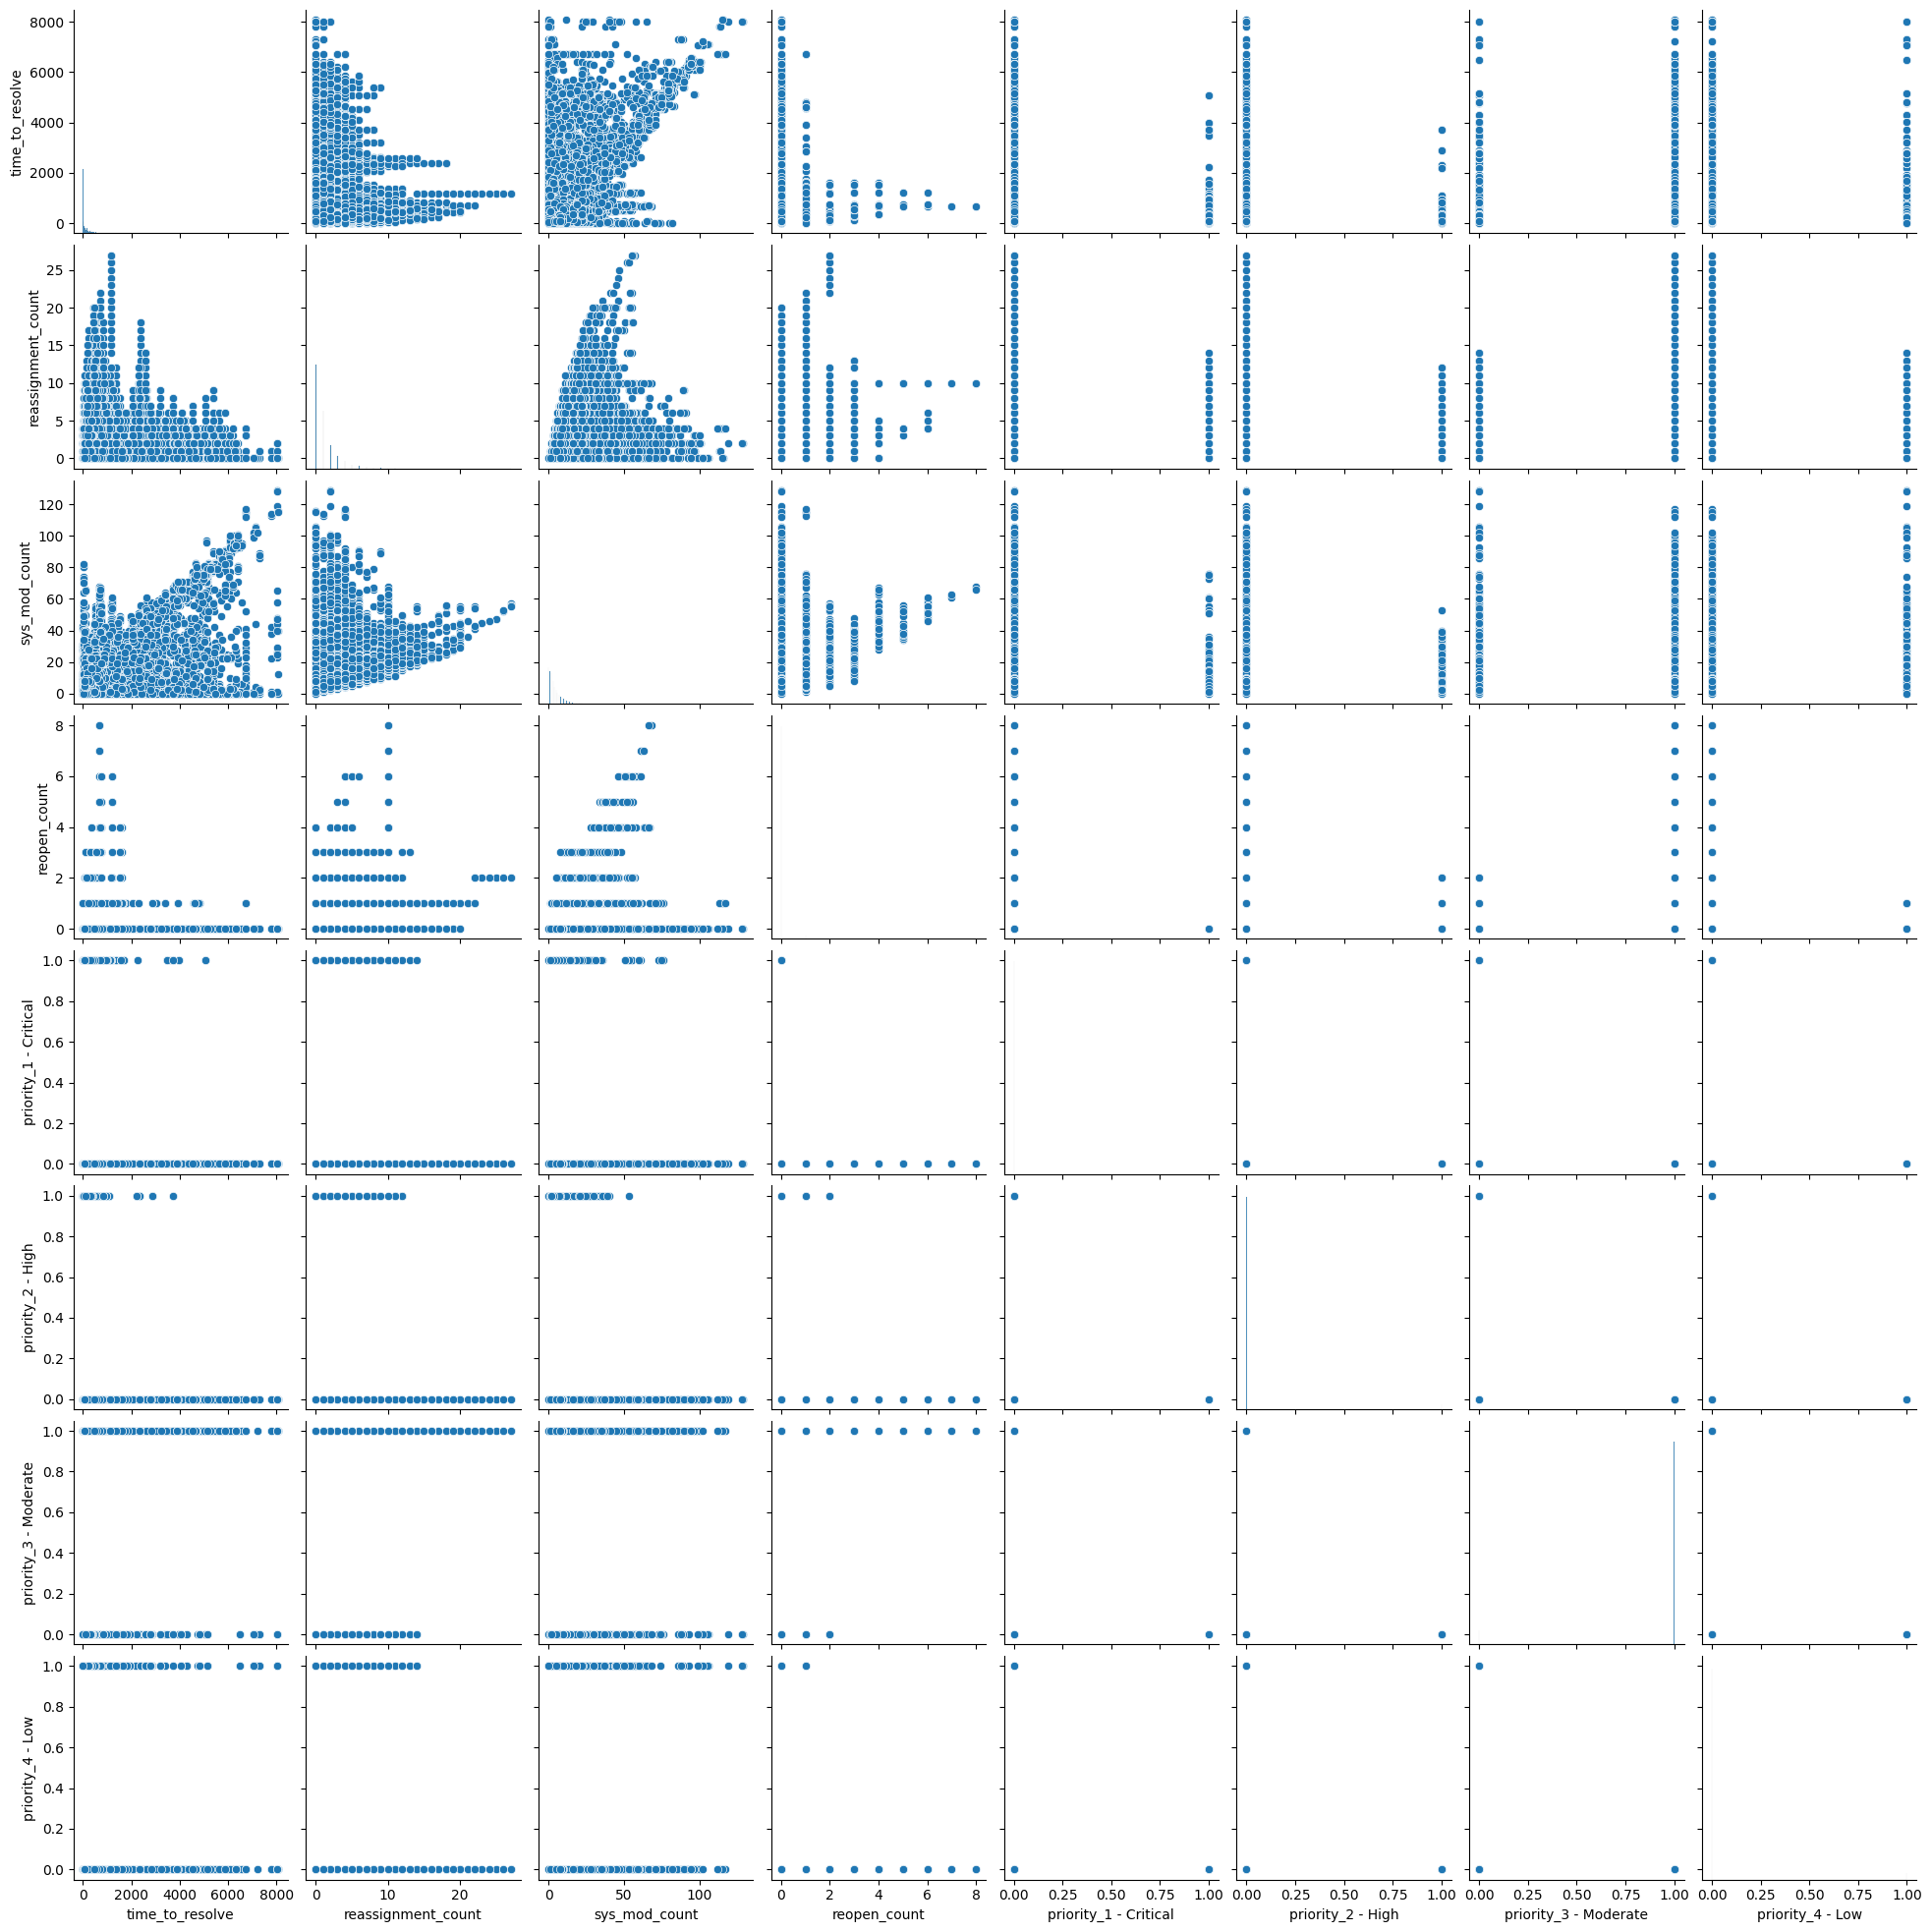

In [54]:
sns.pairplot(train)

Calculemos la matriz de correlacion

In [55]:
train.corr()

,time_to_resolve,reassignment_count,sys_mod_count,reopen_count,priority_1 - Critical,priority_2 - High,priority_3 - Moderate,priority_4 - Low
time_to_resolve,1.000000,0.159309,0.603657,0.053473,-0.006305,-0.021324,-0.009460,0.037999
reassignment_count,0.159309,1.000000,0.523743,0.159757,0.007819,0.031146,-0.020959,-0.001942
sys_mod_count,0.603657,0.523743,1.000000,0.244891,0.025388,0.013806,-0.032084,0.016531
reopen_count,0.053473,0.159757,0.244891,1.000000,-0.014049,0.000070,0.015042,-0.011864
priority_1 - Critical,-0.006305,0.007819,0.025388,-0.014049,1.000000,-0.019165,-0.488316,-0.021840
priority_2 - High,-0.021324,0.031146,0.013806,0.000070,-0.019165,1.000000,-0.558794,-0.024993
priority_3 - Moderate,-0.009460,-0.020959,-0.032084,0.015042,-0.488316,-0.558794,1.000000,-0.636813
priority_4 - Low,0.037999,-0.001942,0.016531,-0.011864,-0.021840,-0.024993,-0.636813,1.000000


<Axes: >

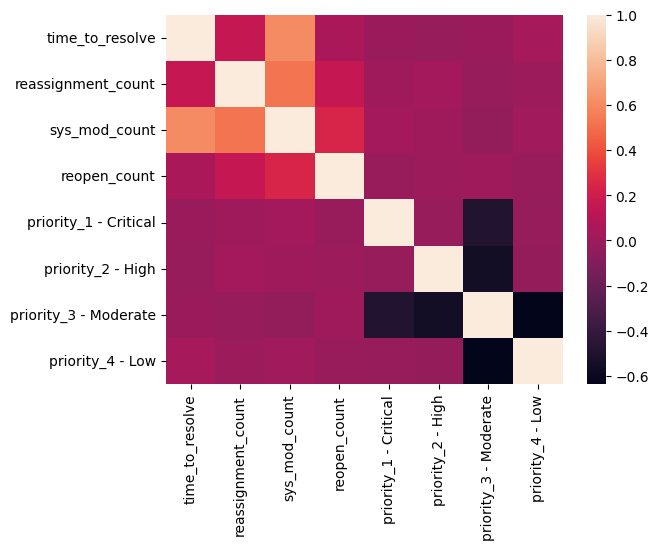

In [56]:
sns.heatmap(train.corr())

Seleccionamos ahora las características y las etiquetas (time_to_resolve)

In [57]:
train_X = train.copy()
test_X = test.copy()

In [58]:
train_y = train_X.pop('time_to_resolve')
test_y = test_X.pop('time_to_resolve')

In [85]:
train_X.head()

,reassignment_count,sys_mod_count,reopen_count,priority_1 - Critical,priority_2 - High,priority_3 - Moderate,priority_4 - Low
7214,0,7,0,0,0,0,1
115415,3,6,0,0,0,1,0
114165,0,2,0,0,0,1,0
1546,1,12,0,0,0,1,0
140332,1,16,0,0,0,1,0


In [60]:
train_y.head()

7214      151.033333
115415     46.016667
114165      0.333333
1546      364.283333
140332    412.050000
Name: time_to_resolve, dtype: float64

In [61]:
train_X.dtypes

reassignment_count       int64
sys_mod_count            int64
reopen_count             int64
priority_1 - Critical    int64
priority_2 - High        int64
priority_3 - Moderate    int64
priority_4 - Low         int64
dtype: object

Construyamos los modelos usando tensorflow

In [62]:
import setuptools.dist # necesario en versión 3.12 de python
import tensorflow as tf

In [63]:
tf.__version__

'2.20.0'

Capa de normalización

In [140]:
tf.keras.layers.Normalization

keras.src.layers.preprocessing.normalization.Normalization

In [141]:
norm = tf.keras.layers.Normalization()

In [142]:
time_norm = tf.keras.layers.Normalization(input_shape=[1,], axis=None)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [143]:
time_to_resolve = train_y.values.reshape(-1, 1)

In [144]:
time_norm.adapt(time_to_resolve)

In [153]:
time_to_resolve2 = test_y.values.reshape(-1, 1)

In [154]:
time_norm.adapt(time_to_resolve2)

## Modelo con múltiples variables de entrada y multicapa con activación ReLU

In [176]:
modelo = tf.keras.Sequential([
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(units=1)   
])

In [183]:
modelo.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [184]:
%%time
history = modelo.fit(
    train_X,
    time_to_resolve,
    epochs=100,
    validation_split = 0.2)

Epoch 1/100
2772/2772 ━━━━━━━━━━━━━━━━━━━━ 2s 558us/step - loss: 178.1006 - val_loss: 168.7439
Epoch 2/100
2772/2772 ━━━━━━━━━━━━━━━━━━━━ 1s 388us/step - loss: 177.5226 - val_loss: 167.3828
Epoch 3/100
2772/2772 ━━━━━━━━━━━━━━━━━━━━ 1s 362us/step - loss: 177.2617 - val_loss: 168.3710
Epoch 4/100
2772/2772 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 176.9941 - val_loss: 167.8662
Epoch 5/100
2772/2772 ━━━━━━━━━━━━━━━━━━━━ 2s 655us/step - loss: 177.0010 - val_loss: 168.1800
Epoch 6/100
2772/2772 ━━━━━━━━━━━━━━━━━━━━ 2s 676us/step - loss: 176.8717 - val_loss: 167.9828
Epoch 7/100
2772/2772 ━━━━━━━━━━━━━━━━━━━━ 1s 391us/step - loss: 176.7863 - val_loss: 170.1101
Epoch 8/100
2772/2772 ━━━━━━━━━━━━━━━━━━━━ 1s 372us/step - loss: 176.8984 - val_loss: 168.2199
Epoch 9/100
2772/2772 ━━━━━━━━━━━━━━━━━━━━ 1s 424us/step - loss: 176.5585 - val_loss: 167.8109
Epoch 10/100
2772/2772 ━━━━━━━━━━━━━━━━━━━━ 1s 357us/step - loss: 176.6319 - val_loss: 170.2596
Epoch 11/100
2772/2772 ━━━━━━━━━━━━━━━━━━━━ 1s 345u

In [185]:
test_res = {}
test_res['modelo'] = modelo.evaluate(
    test_X,
    time_to_resolve2, verbose=0)

In [186]:
test_res['modelo'] = modelo.evaluate(test_X, test_y, verbose=0)

In [187]:
test_res

{'modelo': 176.6849822998047}

867/867 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step


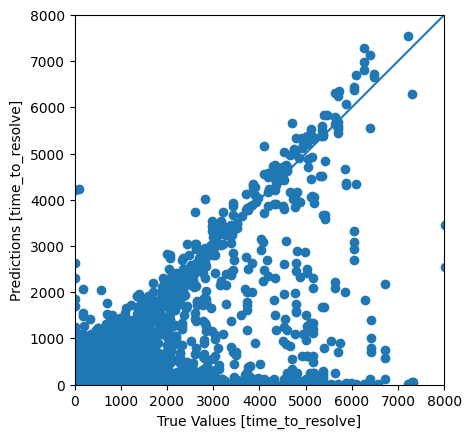

In [194]:
test_pred = modelo.predict(test_X).flatten()

import matplotlib.pyplot as plt

plt.axes(aspect='equal')
plt.scatter(test_y, test_pred)
plt.xlabel('True Values [time_to_resolve]')
plt.ylabel('Predictions [time_to_resolve]')
lims = [0, 8000]
plt.xlim(lims)
plt.ylim(lims)
_=plt.plot(lims, lims)